## Summary
Fit several linear (logistic regression) and non-linear (random forest) classifiers on over 25,000 NBA games from the 2000-01 to the 2020-21 seasons. The dependent variable will be whether the home team won or lost (WL_HOME). The independent variables will be the four factors: eFG%, TOV%, OREB%, FTA Rate. These are not directly stored in the data and will have to be calculated.

## Steps
#### Note: This notebook was created and run with the Kaggle kernel.
1. Retrieve game data from "game" table using SQLite
2. Clean data & EDA with pandas
   * Duplicates: Remove 69 duplicate games (rows)
   * Nulls: Drop 40 rows missing result of the game
   * Ensure no extreme outliers/bad data entry
   * Examine distribution of basic metrics
   * Check for imbalance in target variable
3. Calculate the four factors for both home/away teams in each game
   * Collinearity: Examine correlations between four factors
   * Separation: Ensure no factor completely separates target variable
4. Fit statsmodel Logit and sklearn RandomForestClassifer on 3 feature sets:
   * Only home team's four factors
   * Only away's four factors
   * Both home and away
5. Compute and plot relative importance of features

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from scipy import stats

import statsmodels.api as sm

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

import sqlite3 as sql

import warnings
warnings.filterwarnings('ignore')

import os

if not os.path.exists("images"):
    os.mkdir("images")

seed=37

## 1. Connect to DB and query
The 'game' table contains 149 columns and over 62,000 rows representing individual games dating back to the 1946-47 NBA season. It stores per game metrics for both home and away teams. 

The table does not directly contain the four factors metrics. Therefore, we will compute them from basic metrics found in the table, namely: FG3M, FGA, FGM, FTA, FTM, TOV, OREB, DREB. A full glossary of metrics can be found on the NBA [site](https://www.nba.com/stats/help/glossary/).

In [2]:
db_path = '../input/basketball/basketball.sqlite'
connection = sql.connect(db_path)
print("SQL DB connected.")

SQL DB connected.


In [3]:
all_games_query = """
    SELECT SEASON,
        GAME_DATE,
        MATCHUP_AWAY,
        GAME_ID,
        WL_HOME,
        FG3M_HOME,
        FG3M_AWAY,
        FGA_HOME,
        FGA_AWAY,
        FGM_HOME,
        FGM_AWAY,
        FTA_HOME,
        FTA_AWAY,
        FTM_HOME,
        FTM_AWAY,
        TOV_HOME,
        TOV_AWAY,
        OREB_HOME,
        OREB_AWAY,
        DREB_AWAY,
        DREB_HOME
    FROM Game
    WHERE SEASON > '1999'
    ORDER BY GAME_DATE;
"""
# read query results into dataframe
all_games = pd.read_sql(all_games_query, connection)

# cast numerical metrics as integer
all_games.loc[:,'FG3M_HOME':] = all_games.loc[:,'FG3M_HOME':].astype('int')

all_games.tail()

,SEASON,GAME_DATE,MATCHUP_AWAY,GAME_ID,WL_HOME,FG3M_HOME,FG3M_AWAY,FGA_HOME,FGA_AWAY,FGM_HOME,...,FTA_HOME,FTA_AWAY,FTM_HOME,FTM_AWAY,TOV_HOME,TOV_AWAY,OREB_HOME,OREB_AWAY,DREB_AWAY,DREB_HOME
25168,2020,2021-05-16,DEN @ POR,0022001076,W,18,14,87,98,46,...,26,15,22,14,14,6,11,10,26,40
25169,2020,2021-05-16,DAL @ MIN,0022001071,W,17,16,90,91,49,...,25,20,21,17,10,16,11,11,27,27
25170,2020,2021-05-16,MIL @ CHI,0022001068,W,14,12,87,90,45,...,19,32,14,24,16,12,8,10,31,37
25171,2020,2021-05-16,LAL @ NOP,0022001072,L,9,11,78,96,37,...,21,15,15,9,21,10,8,8,34,39
25172,2020,2021-05-16,UTA @ SAC,0022001077,L,9,18,90,86,42,...,10,25,6,21,13,16,5,9,41,34


## 2. EDA on basic metrics
* Duplicates: Keep only first occurence of 69 games that are recorded twice 
* Nulls: Drop 40 entries/game that were missing a result (null in WL_HOME col)
* Ensure no extreme outliers/bad data entry
* Examine distribution of basic metrics
* Target variable (WL_HOME) imbalance W:0.59 L:0.41
    * In line with expectation that home teams have advantage
    * Will use stratification in CV scoring and train/test split

In [4]:
all_games.shape

(25173, 21)

In [5]:
# check for duplicate rows (i.e. games recorded more than once)
all_games[all_games.duplicated()]

,SEASON,GAME_DATE,MATCHUP_AWAY,GAME_ID,WL_HOME,FG3M_HOME,FG3M_AWAY,FGA_HOME,FGA_AWAY,FGM_HOME,...,FTA_HOME,FTA_AWAY,FTM_HOME,FTM_AWAY,TOV_HOME,TOV_AWAY,OREB_HOME,OREB_AWAY,DREB_AWAY,DREB_HOME
2379,2002,2002-10-29,SAS @ LAL,0020200003,L,4,3,85,71,27,...,30,46,24,32,18,20,17,11,41,31
2385,2002,2002-10-30,MIL @ PHI,0020200005,W,5,10,86,79,31,...,37,23,28,19,22,17,24,6,29,34
9194,2007,2008-02-10,SAS @ BOS,0020700749,W,9,11,71,79,33,...,34,13,23,9,15,15,10,7,30,36
15631,2013,2013-11-03,BKN @ ORL,0021300043,W,7,4,89,89,42,...,22,15,16,14,15,12,13,11,31,41
15671,2013,2013-11-08,BKN @ WAS,0021300077,W,10,6,88,88,41,...,26,29,20,20,17,23,7,11,40,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24615,2020,2021-03-04,DET @ NYK,0022000565,W,9,14,83,80,45,...,19,15,15,12,13,13,12,6,23,35
24913,2020,2021-04-15,BOS @ LAL,0022000842,L,12,14,98,85,44,...,19,13,13,11,8,21,11,7,41,25
24915,2020,2021-04-15,MIL @ ATL,0022000840,L,14,16,86,95,39,...,19,17,17,12,12,9,8,14,37,31
24953,2020,2021-04-20,BKN @ NOP,0022000878,L,12,14,91,89,51,...,24,28,15,22,13,13,7,10,34,30


In [6]:
# drop duplicates, keeping only the first occurence
all_games = all_games[all_games.duplicated()==False]
all_games.shape

(25104, 21)

In [7]:
#### check for null values
#### 40 games out of 25104 are missing a result
all_games.isnull().sum()

SEASON           0
GAME_DATE        0
MATCHUP_AWAY     0
GAME_ID          0
WL_HOME         40
FG3M_HOME        0
FG3M_AWAY        0
FGA_HOME         0
FGA_AWAY         0
FGM_HOME         0
FGM_AWAY         0
FTA_HOME         0
FTA_AWAY         0
FTM_HOME         0
FTM_AWAY         0
TOV_HOME         0
TOV_AWAY         0
OREB_HOME        0
OREB_AWAY        0
DREB_AWAY        0
DREB_HOME        0
dtype: int64

In [8]:
#### drop rows/games missing a result
all_games.dropna(inplace=True)
all_games.isnull().sum()

SEASON          0
GAME_DATE       0
MATCHUP_AWAY    0
GAME_ID         0
WL_HOME         0
FG3M_HOME       0
FG3M_AWAY       0
FGA_HOME        0
FGA_AWAY        0
FGM_HOME        0
FGM_AWAY        0
FTA_HOME        0
FTA_AWAY        0
FTM_HOME        0
FTM_AWAY        0
TOV_HOME        0
TOV_AWAY        0
OREB_HOME       0
OREB_AWAY       0
DREB_AWAY       0
DREB_HOME       0
dtype: int64

In [9]:
all_games.describe().T

,count,mean,std,min,25%,50%,75%,max
FG3M_HOME,25064.0,7.550551,3.975185,0.0,5.0,7.0,10.0,28.0
FG3M_AWAY,25064.0,7.402689,3.935190,0.0,5.0,7.0,10.0,29.0
FGA_HOME,25064.0,82.804062,7.855030,54.0,77.0,82.0,88.0,125.0
FGA_AWAY,25064.0,82.741941,7.902790,55.0,77.0,83.0,88.0,129.0
FGM_HOME,25064.0,38.040496,5.371072,19.0,34.0,38.0,42.0,63.0
FGM_AWAY,25064.0,37.060086,5.300873,16.0,33.0,37.0,41.0,63.0
FTA_HOME,25064.0,24.409911,7.796177,1.0,19.0,24.0,29.0,64.0
FTA_AWAY,25064.0,23.424154,7.502644,1.0,18.0,23.0,28.0,64.0
FTM_HOME,25064.0,18.533993,6.311619,1.0,14.0,18.0,23.0,48.0
FTM_AWAY,25064.0,17.745891,6.105735,1.0,13.0,17.0,22.0,52.0


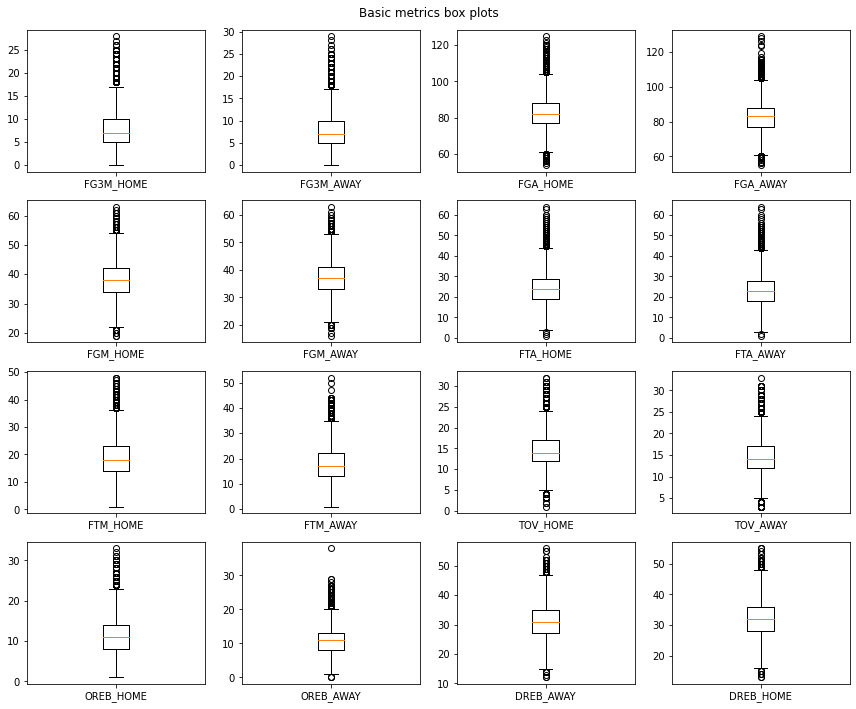

In [10]:
#### boxplots for each base metric
#### no extreme outliers of concern
fig, axs = plt.subplots(4,4,figsize=(12,10))
for i, col in enumerate(all_games.loc[:,'FG3M_HOME':]):
    axs.flat[i].boxplot(all_games[col], labels=[col])
plt.suptitle('Basic metrics box plots')
plt.tight_layout()
plt.show()

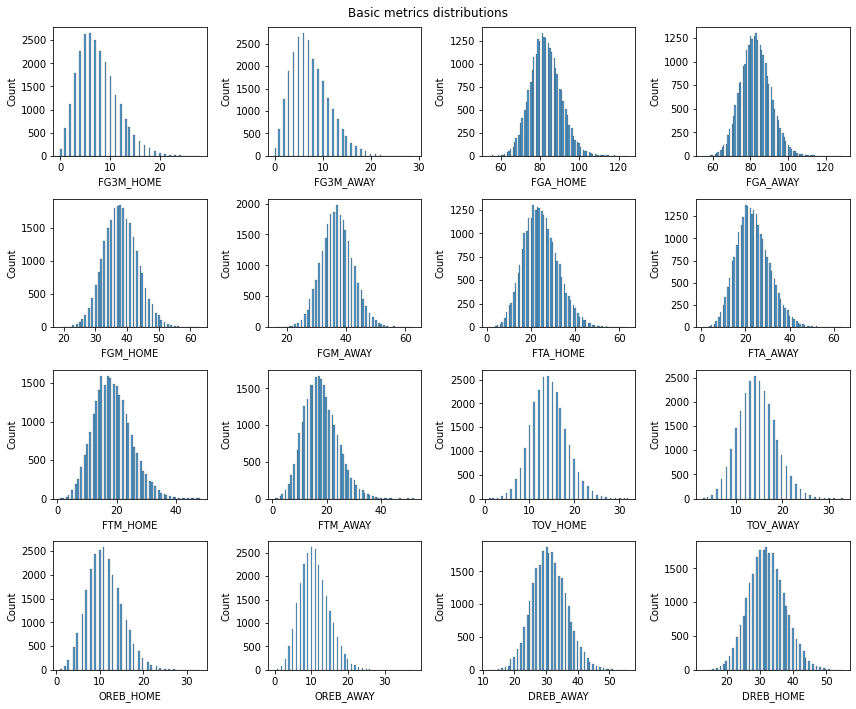

In [11]:
#### distribution of each basic metric
fig, axs = plt.subplots(4,4,figsize=(12,10))
plt.suptitle('Basic metrics distributions')
for i, feat in enumerate(all_games.loc[:,'FG3M_HOME':]):
    sns.histplot(all_games[feat],kde=False, ax=axs.flat[i])
plt.tight_layout()
plt.show()

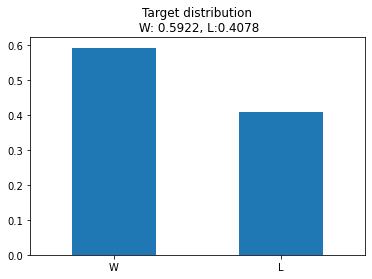

In [12]:
#### target variable distribution
# slightly unbalanced, can stratify in scoring and train/test split
# 'home court' advantage results in more wins than losses for the home team
wl_pct = all_games['WL_HOME'].value_counts()/all_games['WL_HOME'].count()
wl_pct.plot(kind='bar')
plt.title(f'Target distribution\n W: {wl_pct.W:.4f}, L:{wl_pct.L:.4f}')
plt.xticks(rotation=0)
plt.show()

## 3. Calculating the four factors
The features for our models will be the four factors (eFG%, TOV%, OREB%, FTA Rate).
* Calculate the four factors for both home and away teams for each game
    * Forumlas for each factor are shown below. See NBA [stats glossary](https://www.nba.com/stats/help/glossary/) for more.
* Check features for collinearity
* Check feature distributions
    * Each feature by definition is already on a \[0,1\] scale
* Ensure no feature completely separates target variable

$$
{eFG\%} = {{FGM+0.5*FG3M}\over {FGA}}
$$
.
$$
{TOV\%} = {{TOV}\over{FGA + 0.44*FTA + TOV}}
$$
.
$$
{OREB\%} = {{OREB}\over {OREB+DREB_{Opp}}}
$$
.
$$
{FTA Rate} = {{FTA}\over {FGA}}
$$

In [13]:
# calculate the four factors for both home and away teams

# get base metrics cols to later drop them
num_cols = all_games.select_dtypes('number').columns

all_adv = all_games.copy()

# home team four factors
all_adv['EFG_PCT_H'] = (all_adv.FGM_HOME + 0.5*all_adv.FG3M_HOME)/all_adv.FGA_HOME
all_adv['TOV_PCT_H'] = all_adv.TOV_HOME/(all_adv.FGA_HOME + (0.44*all_adv.FTA_HOME) + all_adv.TOV_HOME)
all_adv['ORB_PCT_H'] = all_adv.OREB_HOME/(all_adv.OREB_HOME + all_adv.DREB_AWAY)
all_adv['FT_RT_H'] = all_adv.FTA_HOME/all_adv.FGA_HOME

# away team four factors
all_adv['EFG_PCT_A'] = (all_adv.FGM_AWAY + 0.5*all_adv.FG3M_AWAY)/all_adv.FGA_AWAY
all_adv['TOV_PCT_A'] = all_adv.TOV_AWAY/(all_adv.FGA_AWAY + (0.44*all_adv.FTA_AWAY) + all_adv.TOV_AWAY)
all_adv['ORB_PCT_A'] = all_adv.OREB_AWAY/(all_adv.DREB_HOME + all_adv.OREB_AWAY)
all_adv['FT_RT_A'] = all_adv.FTA_AWAY/all_adv.FGA_AWAY

# drop unused columns and basic metrics
all_adv.drop(num_cols, axis=1, inplace=True)
all_adv.drop(['SEASON', 'GAME_DATE', 'MATCHUP_AWAY','GAME_ID'], axis=1, inplace=True)

# encode target variable, replace W with 1, L with 0
all_adv['WL_HOME'] = all_adv.WL_HOME.replace(['W','L'], [1,0])

all_adv.tail()

,WL_HOME,EFG_PCT_H,TOV_PCT_H,ORB_PCT_H,FT_RT_H,EFG_PCT_A,TOV_PCT_A,ORB_PCT_A,FT_RT_A
25168,1,0.632184,0.124511,0.297297,0.298851,0.520408,0.054250,0.200000,0.153061
25169,1,0.638889,0.090090,0.289474,0.277778,0.571429,0.138169,0.289474,0.219780
25170,1,0.597701,0.143678,0.205128,0.218391,0.488889,0.103377,0.212766,0.355556
25171,0,0.532051,0.194013,0.190476,0.269231,0.526042,0.088810,0.170213,0.156250
25172,0,0.516667,0.121043,0.108696,0.111111,0.581395,0.141593,0.209302,0.290698


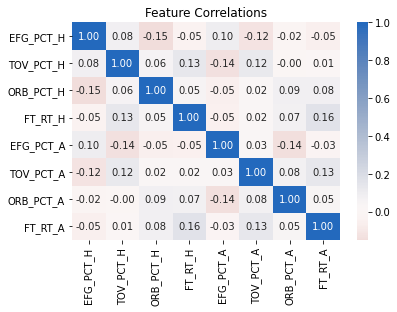

In [14]:
# check correlation between factors/features
col_corr = all_adv.loc[:,'EFG_PCT_H':].corr()
sns.heatmap(col_corr, center=0, cmap='vlag_r', annot=True, fmt='.2f')
plt.title('Feature Correlations')
plt.show()

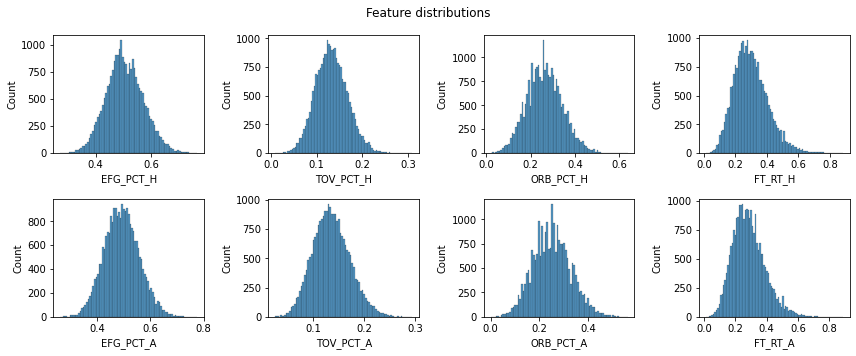

In [15]:
# distribution for each feature
fig, axs = plt.subplots(2,4,figsize=(12,5))
plt.suptitle('Feature distributions')
for i, feat in enumerate(all_adv.loc[:,'EFG_PCT_H':]):
    sns.histplot(all_adv[feat],kde=False, ax=axs.flat[i])
plt.tight_layout()
plt.show()

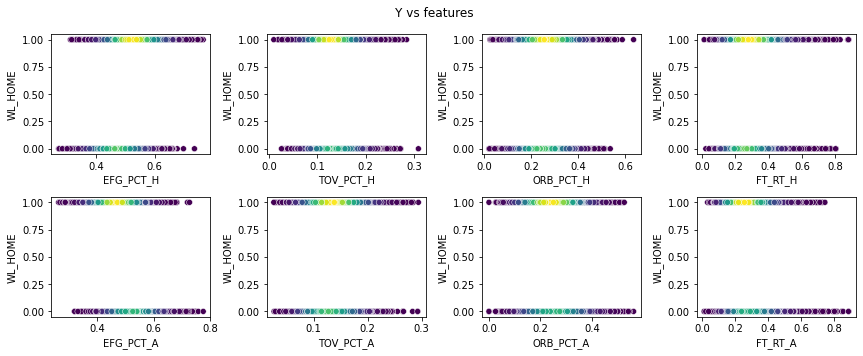

In [16]:
# plot each feature against target
# ensure no feature completely separates the target variable
fig, axs = plt.subplots(2,4,figsize=(12,5))
plt.suptitle('Y vs features')
for i, col in enumerate(all_adv.loc[:,'EFG_PCT_H':]):
    values = np.vstack([all_adv[col], all_adv['WL_HOME']])
    kernel = stats.gaussian_kde(values)(values)
    sns.scatterplot(all_adv[col], all_adv['WL_HOME'], ax=axs.flat[i], c=kernel)
plt.tight_layout()
plt.show()

## 4. Model Fitting
Fit 2 types of classifiers on 3 sets of features for 6 total fits.
* Classifiers:
    1. Logistic Regression/Logit (statsmodels)
    2. Random Forest (sklearn)
* Feature sets:
    1. Home only factors, 4 features (EFG_PCT_H, TOV_PCT_H, ORB_PCT_H, FR_RT_H)
    2. Away only factors, 4 features (EFG_PCT_A, ...)
    3. Both home and away factors, 8 features
    
Statsmodels Logit is favored as it produces very similar results as scikit-learn's LogisticRegression without regularization (penalty='none') and offers detailed results with p-values, pseudo R2, and more.

In [17]:
# define cross validated accuracy using stratification
def cv_accuracy(X, y, model):

    kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)    
    score = cross_val_score(model, X, y, cv=kfolds, scoring="accuracy")
    
    return score.mean()

In [18]:
# train test splits using stratification
X = all_adv.copy()
y = X.pop('WL_HOME')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=seed,
                                                    shuffle=True,
                                                   stratify=y)

# select home features for home only models
X_train_h = X_train.loc[:,X_train.columns.str.endswith('H')]
X_test_h = X_test.loc[:,X_test.columns.str.endswith('H')]

# select away features for away only models
X_train_a = X_train.loc[:,X_train.columns.str.endswith('A')]
X_test_a = X_test.loc[:,X_test.columns.str.endswith('A')]


In [19]:
#### Fit, score, and get coefficients for logistic regression models ####
print(4*'#', 'LogisticRegression OOS Accuracies', '#'*4)

# home features only logit
X_train_hs = sm.add_constant(X_train_h) # must add column of ones for intercept to be fitted
X_test_hs = sm.add_constant(X_test_h)
lr_h = sm.Logit(y_train, X_train_hs)
lr_h_res =lr_h.fit(disp=0) # suppress fitting messages
lr_oos_h=accuracy_score(y_test,round(lr_h_res.predict(X_test_hs))) # predict returns probabilities, must round to get class
lr_h_coefs = lr_h_res.params.drop('const').values
print(f'Home only: {lr_oos_h:.4f}')


# away features only logit
X_train_as = sm.add_constant(X_train_a)
X_test_as = sm.add_constant(X_test_a)
lr_a = sm.Logit(y_train, X_train_as)
lr_a_res =lr_a.fit(disp=0)
lr_oos_a=accuracy_score(y_test,round(lr_a_res.predict(X_test_as)))
lr_a_coefs = lr_a_res.params.drop('const').values
print(f'Away only: {lr_oos_a:.4f}')


# home and away features logit 
X_train_s = sm.add_constant(X_train)
X_test_s = sm.add_constant(X_test)
lr = sm.Logit(y_train, X_train_s)
lr_res =lr.fit(disp=0)
lr_oos=accuracy_score(y_test,round(lr_res.predict(X_test_s)))
lr_coefs = lr_res.params.drop('const').values
print(f'Home+Away: {lr_oos:.4f}')

#### LogisticRegression OOS Accuracies ####
Home only: 0.7335
Away only: 0.7368
Home+Away: 0.9392


In [20]:
lr_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                WL_HOME   No. Observations:                18798
Model:                          Logit   Df Residuals:                    18789
Method:                           MLE   Df Model:                            8
Date:                Mon, 23 Aug 2021   Pseudo R-squ.:                  0.7907
Time:                        21:30:21   Log-Likelihood:                -2659.5
converged:                       True   LL-Null:                       -12709.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4113      0.476     -0.864      0.387      -1.344       0.521
EFG_PCT_H     82.5953      1.624     50.872      0.000      79.413      85.778
TOV_PCT_H    -74.1565      1.721    -43.083      0.000     -77.530     -70.783
ORB_PCT_H     25.0822      0.652     38.496      0.000      23.805      26.359
FT_RT_H       13.3651      0.416     32.166      0.000      12.551      14.179
EFG_PCT_A    -81.8966      1.602    -51.122      0.000     -85.036     -78.757
TOV_PCT_A     72.8845      1.676     43.480      0.000      69.599      76.170
ORB_PCT_A    -24.2794      0.649    -37.426      0.000     -25.551     -23.008
FT_RT_A      -13.0825      0.415    -31.517      0.000     -13.896     -12.269
==============================================================================

Possibly complete quasi-separation: A fraction 0.23 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [21]:
#### Fit, score, and get feature importances random forest models ####
print(4*'#', 'RandomForest Accuracies', '#'*4)
print(6*'#', 'CV, OOS', '#'*6)

# home features only models
rf_h = RandomForestClassifier(random_state=seed)
rf_h.fit(X_train_h, y_train)
rf_oos_h=accuracy_score(y_test,rf_h.predict(X_test_h))
print(f'Home only: {cv_accuracy(X_train_h, y_train, rf_h):.4f}, {rf_oos_h:.4f}')


# away features only models
rf_a = RandomForestClassifier(random_state=seed)
rf_a.fit(X_train_a, y_train)
rf_oos_a=accuracy_score(y_test,rf_a.predict(X_test_a))
print(f'Away only: {cv_accuracy(X_train_a, y_train, rf_a):.4f}, {rf_oos_a:.4f}')


# home and away features models
rf = RandomForestClassifier(random_state=seed)
rf.fit(X_train, y_train)
rf_oos=accuracy_score(y_test,rf.predict(X_test))
print(f'Home+Away: {cv_accuracy(X_train, y_train, rf):.4f}, {rf_oos:.4f}')

#### RandomForest Accuracies ####
###### CV, OOS ######
Home only: 0.7104, 0.7154
Away only: 0.7129, 0.7065
Home+Away: 0.9098, 0.9113


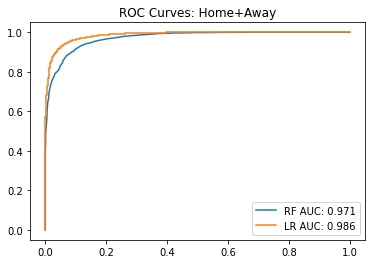

In [22]:
#### ROC curves and AUC scores for home+away features models ####

# auc scores
rf_auc=roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]) # takes predicted probabilities not class
lr_auc=roc_auc_score(y_test, lr_res.predict(X_test_s).values) # statsmodels predicts already returns probabilities

# roc curves
rf_roc = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
lr_roc = roc_curve(y_test, lr_res.predict(X_test_s).values)

# plotting ROC curves, AUC reported in legend
plt.plot(rf_roc[0], rf_roc[1], label=f'RF AUC: {rf_auc:.3f}')
plt.plot(lr_roc[0], lr_roc[1], label=f'LR AUC: {lr_auc:.3f}')
plt.legend()
plt.title('ROC Curves: Home+Away')
plt.show()

### 4.1 Model Fitting Results
* LR returned p-values < 0.05 for all coefficients in all models
* Including both home and away team metrics yields the best accuracies for both RF and LR.
* LR scores slightly better than RF as measured by both out of sample accuracy and out of sample AUC.

## 5. Relative Importance of Features
* Examine relative importance of features for each of the 6 models fitted
    * Random forest - normalized feature importances
    * Logistic regression - express each coef as a percent of the sum of abs(coefficients)


In [23]:
# function for getting relative importance of features in logistic regression
# absolute value of each coefficent / sum of absolute values of all coefs
def rel_imp(coefs):
    rel_imp = abs(coefs)/sum(abs(coefs))
    return rel_imp

In [24]:
#### create dfs of relative feature importance for each feature set ####
# include oos accuracies in column names to show in plot legend

# home only models
# create df with cols for feature name and relative feature importance for RF and LR
imps_h = pd.DataFrame({'feature':X_test_h.columns,
                       f'RF: {rf_oos_h:.2%}':rf_h.feature_importances_,
                       f'LR: {lr_oos_h:.2%}':rel_imp(lr_h_coefs)})
# unpivot the df to long format using pd.melt
# allows us to use hue argument in sns.barplot later
imps_hplot = pd.melt(imps_h, id_vars=['feature'],
                     value_name='relative_importance',
                     var_name='model_oos_accuracy')

# away only models - same procedure as home only models
imps_a = pd.DataFrame({'feature':X_test_a.columns,
                        f'RF: {rf_oos_a:.2%}':rf_a.feature_importances_,
                        f'LR: {lr_oos_a:.2%}':rel_imp(lr_a_coefs)})
imps_aplot = pd.melt(imps_a, id_vars=['feature'],
                     value_name='relative_importance',
                     var_name='model_oos_accuracy')

# home+away models - same as above
imps = pd.DataFrame({'feature':X_test.columns,
                     f'RF: {rf_oos:.2%}':rf.feature_importances_,
                     f'LR: {lr_oos:.2%}':rel_imp(lr_coefs)})
imps_plot = pd.melt(imps, id_vars=['feature'],
                    value_name='relative_importance',
                    var_name='model_oos_accuracy')

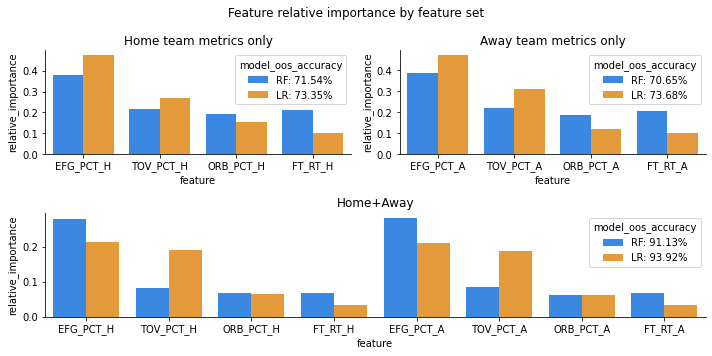

In [25]:
#### 3 subplots of relative importance for each feature set ####

rf_color ='#1f85ff'
lr_color = '#ff9e1f'

# create 2x2 grid (3rd subplot runs entire width of 2nd row)
fig = plt.figure(tight_layout=True, figsize=(10,5))
gs = gridspec.GridSpec(2, 2)

# subplot 1, top left - home only rf & lr
ax = fig.add_subplot(gs[0,0])
ax.set_title('Home team metrics only')
sns.barplot(data=imps_hplot, x='feature', y='relative_importance',
            hue='model_oos_accuracy',ax=ax, palette=[rf_color,lr_color])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# subplot 2, top right - away only rf & lr
ax = fig.add_subplot(gs[0,1])
ax.set_title('Away team metrics only')
sns.barplot(data=imps_aplot, x='feature', y='relative_importance',
            hue='model_oos_accuracy',ax=ax, palette=[rf_color,lr_color])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# subplot 3, bottom full row - home & away, rf & lr
ax = fig.add_subplot(gs[1,:])
ax.set_title('Home+Away')
sns.barplot(data=imps_plot, x='feature', y='relative_importance',
            hue='model_oos_accuracy',ax=ax, palette=[rf_color,lr_color])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.suptitle('Feature relative importance by feature set')
fig.patch.set_facecolor('white')
plt.savefig('images/relimp.png', transparent=False)
plt.savefig('images/relimp.svg', transparent=False)

plt.show()

### 5.1 Feature Importance Results
* Including both home and away four factors results in a better fit than only considering one team's factors
    * Over 90% accuracy for home+away vs. just over 70% for one side's four factors
    * Unsurprisingly, knowing how both teams performed gives a better idea of who won. 
* All 6 models line up with Oliver's findings that shooting (EFG_PCT) is clearly the most important factor in determining the winner of a game
    * Unsurprisingly, the more shots you make/the less your opponent makes the likelier you are to win
* Turnovers (TOV_PCT) are second most important to a varying degree
* Rebounding (ORB_PCT) and free throws (FT_RT) tend to be the least important of the factor
    * Although random forest models tend to weight turnovers, rebounding, and free throws roughly equally
* Overall, the results largely follow Oliver's order of importance. Understanding the factors can help teams determine their strategy for coaching and assembling rosters. Additionally, considering the "eight factors" can help predict winners and losers.



In [26]:
# see all relative importance for all models in a single df
all_imps=imps.merge(imps_h, how='left', left_on='feature', right_on='feature')
all_imps=all_imps.merge(imps_a, how='left',left_on='feature', right_on='feature')
all_imps

,feature,RF: 91.13%,LR: 93.92%,RF: 71.54%,LR: 73.35%,RF: 70.65%,LR: 73.68%
0,EFG_PCT_H,0.279394,0.213236,0.379821,0.474212,NaN,NaN
1,TOV_PCT_H,0.082528,0.191450,0.214465,0.271045,NaN,NaN
2,ORB_PCT_H,0.069597,0.064755,0.194080,0.151878,NaN,NaN
3,FT_RT_H,0.067842,0.034505,0.211635,0.102866,NaN,NaN
4,EFG_PCT_A,0.283809,0.211432,NaN,NaN,0.384539,0.471302
5,TOV_PCT_A,0.085632,0.188166,NaN,NaN,0.219936,0.308326
6,ORB_PCT_A,0.063811,0.062682,NaN,NaN,0.188379,0.121626
7,FT_RT_A,0.067388,0.033775,NaN,NaN,0.207146,0.098746
